# Neurog Internship: (Task 10 - Improving On The Day 9 Task: Improving & Correcting The Backtesting Algorithm. The backtesting Was Not Producing Correct Results, So Correcting The Bug In The Implementation. Also Writing A Python Script With The Combination Of A Config File To Run The Python Backtesting Code.... Making It Generic) - Day 10, 11, 12, 13 & 14

## All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Technical Analysis Library Modules
from ta.momentum import StochRSIIndicator
from ta.momentum import RSIIndicator

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [2]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## MACD Indicator Function

In [3]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## RSI Indicator Function

In [4]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_rsi_signals(df: pd.DataFrame, rsi_lower: int = 30, rsi_upper: int = 70) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## Stochastic RSI Indicator Function

In [5]:
def calculate_stochrsi(
    df: pd.DataFrame,
    window: int = 14,
    smooth1: int = 3,
    smooth2: int = 3,
    fillna: bool = False,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) for a given DataFrame using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The paramter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values.
    """

    # Calculate Stochastic RSI
    stoch_rsi = StochRSIIndicator(
        close=df['Close'],
        window = window,
        smooth1 = smooth1,
        smooth2 = smooth2,
        fillna = fillna
    )

    # Add Stochastic RSI values to the DataFrame
    df['StochRSI'] = stoch_rsi.stochrsi()
    
    df['StochRSI_K'] = stoch_rsi.stochrsi_k() * 100
    df['StochRSI_D'] = stoch_rsi.stochrsi_d() * 100

    return df

def generate_stochrsi_signals(
    df: pd.DataFrame,
    stochrsi_upper: int = 0.7,
    stochrsi_lower: int = 0.3,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) and generate buy/sell signals for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The parameter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values and signals.
    """
    # Generate signals
    df['Signal'] = 0
    df['Signal'] = np.where((df['StochRSI'].shift(1) < 0.2) & (df['StochRSI'] >= 0.2), 1, df['Signal'])  # Buy signal
    df['Signal'] = np.where((df['StochRSI'].shift(1) > 0.8) & (df['StochRSI'] <= 0.8), -1, df['Signal'])  # Sell signal

    return df

## OBV Indicator Function

In [6]:
def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on On-Balance Volume (OBV) indicator.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
    """
    df['OBV'] = 0  # Initialize OBV column with zeros
    df['Signal'] = 0  # Initialize Signal column with zeros

    # Calculate OBV values
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]

    # Generate signals based on OBV
    df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

    return df

## Backtesting Function: Day 13's End

In [19]:
def generate_backtest_df_1(data, data_1m, initial_balance=1000, transaction_fee=0.01):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.
        data_1m (pd.DataFrame): DataFrame containing 1-minute interval data with 'Open' prices.
        initial_balance (float): Initial balance for the backtest.
        transaction_fee (float): Transaction fee as a percentage of the current balance for each trade.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL', 'Balance'.
    """
    # For index name
    index_name = data.index.name

    # Extract necessary columns as numpy arrays
    open_prices_1m = data_1m['Open']
    open_prices = data['Open']
    signals = data['Signal'].values
    index_values = data.index.values

    # Determine trade entry points
    # Find where the signal is non-zero (ignoring initial zeros)
    # Find indices where the value changes from -1 to 1 or from 1 to -1
    # Pick those indices where there is a change from -1 to 1 or 1 to -1 (in the original array)
    signal_array = np.array(signals)  
    non_zero_indices = np.flatnonzero(signal_array != 0)
    changes = np.where(np.diff(signal_array[non_zero_indices]))[0] + 1
    changes = np.insert(changes, 0, 0)
    entry_indices = non_zero_indices[changes]
    
    # Initialize the exit indices for tp or sl hit (takes the lowest: which happened first)
    exit_index_tp = None
    exit_index_sl = None
    
    # Initialize the backtest results array
    backtest_data = []

    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    # Initialize the balance
    balance = initial_balance
    
    # Iterate through all signal changes
    for i in range(len(entry_indices)):
        if i == len(entry_indices) - 1:
            trade_end = len(open_prices) - 1
        else:
            trade_end = entry_indices[i + 1]
            
        trade_start = entry_indices[i]
        direction_start = 'long' if signals[trade_start] == 1 else 'short' # Could very well be signals[trade_end]: check after!
        direction_end = 'long' if signals[trade_end] == 1 else 'short'
        entry_price = open_prices[trade_start]
        
        # Calculate take profit and stop loss prices
        if direction_start == 'long':
            tp_price = entry_price * (1 + tp)
            sl_price = entry_price * (1 - sl)
        else:
            tp_price = entry_price * (1 - tp)
            sl_price = entry_price * (1 + sl)
        
        # Find the exit point for the trade
        exit_index = trade_end
        action = 'direction'  # Default action is direction change
        
        # Note times for trade start and end
        trade_start_time = index_values[trade_start]
        trade_end_time = index_values[trade_end]
        
        # tp or sl hit flag
        flag = False
        flag2 = False
        
        if direction_start == 'long':
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= sl_price)[0]
        else:
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= sl_price)[0]

        if len(tp_hit) > 0:
            exit_index_tp = tp_hit[0]
            exit_index = exit_index_tp
            action = 'tp'
            flag = True
        if len(sl_hit) > 0 and (len(tp_hit) == 0 or sl_hit[0] < tp_hit[0]):
            exit_index_sl = sl_hit[0]
            exit_index = exit_index_sl
            action = 'sl'
            flag2 = True
            
        if action == 'direction':
            close_price = open_prices[exit_index]
        else:
            if flag and flag2:
                exit_index = min(exit_index_tp, exit_index_sl) # select which happened first
                action = 'tp' if exit_index == exit_index_tp else 'sl'
            close_price = open_prices_1m[trade_start_time:trade_end_time][exit_index]
        
        # Record the trade entry and exit
        backtest_data.append([index_values[trade_start], direction_start, entry_price, 0, None])
        if flag or flag2:
            backtest_data.append([open_prices_1m[trade_start_time:trade_end_time].index[exit_index], direction_end, entry_price, close_price, action])
        else:
            backtest_data.append([index_values[exit_index], direction_end, entry_price, close_price, action])

    backtest_df = pd.DataFrame(backtest_data, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][0:-1:2].values

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    # Update balance considering PNL and transaction fees
    balances = [initial_balance]
    for pnl_value in pnl:
        transaction_cost = balances[-1] * transaction_fee
        new_balance = balances[-1] + (balances[-1] * (pnl_value / 100)) - transaction_cost
        balances.append(new_balance)
    
    # Insert the balance values back into the DataFrame
    backtest_df['Balance'] = pd.Series(np.repeat(balances[1:], 2)[:len(backtest_df)])

    return backtest_df

# Backtesting Function: Day 15's End - Final

In [29]:
def generate_backtest_df_2(data, data_1m, initial_balance=1000, transaction_fee=0.01):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.
        data_1m (pd.DataFrame): DataFrame containing 1-minute interval data with 'Open' prices.
        initial_balance (float): Initial balance for the backtest.
        transaction_fee (float): Transaction fee as a percentage of the current balance for each trade.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL', 'Balance'.
    """
    
    def find_first_change(signal):
        # Convert the list to a numpy array
        signal_array = np.array(signal)

        # Find indices of non-zero elements
        non_zero_indices = np.flatnonzero(signal_array != 0)

        # Find where the value changes
        changes = np.where(np.diff(signal_array[non_zero_indices]))[0] + 1
        changes = np.insert(changes, 0, 0)
        
        if len(non_zero_indices) < 1:
            return signal.index[0], signal.index[-1]

        if len(changes) == 1:
            # Get the indices of the first change
            first_change_start = non_zero_indices[changes[0]]
            first_change_end = len(signal) - 1
        else:
            # Get the indices of the first change
            first_change_start = non_zero_indices[changes[0]]
            first_change_end = non_zero_indices[changes[0 + 1]]
        
        # Get the starting and ending time of the direction change
        trade_start_time = signal.index[first_change_start]
        trade_end_time = signal.index[first_change_end]

        # Return the start and end time tuple
        return (trade_start_time, trade_end_time)
    
    # For index name
    index_name = data.index.name

    # Extract necessary columns as numpy arrays
    high_prices_1m = data_1m['High']
    low_prices_1m = data_1m['Low']
    open_prices_1m = data_1m['Open']
    open_prices = data['Open']
    signals = data['Signal']
    
    # Initialize the exit indices for tp or sl hit (takes the lowest: which happened first)
    exit_index_tp = None
    exit_index_sl = None
    
    # Initialize the backtest results array
    backtest_data = []

    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    # Initialize the balance
    balance = initial_balance
    
    # Get last date
    last_date = signals.index[-1]
    
    # Initializing List To Store Directions For The Trade
    directions = []
    
    # Iterate
    while(True):
        trade_start_time, trade_end_time = find_first_change(signals)
            
        direction_start = 'long' if signals[trade_start_time] == 1 else 'short'
        direction_end = 'long' if signals[trade_end_time] == 1 else 'short'
        entry_price = open_prices[trade_start_time]
        
        # Calculate take profit and stop loss prices
        if direction_start == 'long':
            tp_price = entry_price * (1 + tp)
            sl_price = entry_price * (1 - sl)
        else:
            tp_price = entry_price * (1 - tp)
            sl_price = entry_price * (1 + sl)
        
        # Find the exit point for the trade
        exit_index = None
        action = 'direction'  # Default action is direction change
        
        # getting to the closest time of that interval
        # Assuming trade_end_time is a datetime object
        # Basically doing this, so the tp and sl hit only checks and
        # compares from the (T + 1)th time till the trade end time.
        trade_start_time_matching = pd.to_datetime(trade_start_time)
        add_minute = pd.Timedelta('1m')
        trade_start_time_matching = trade_start_time_matching + add_minute
        
        if direction_start == 'long':
            tp_hit = np.where(high_prices_1m[trade_start_time_matching:trade_end_time] >= tp_price)[0]
            sl_hit = np.where(low_prices_1m[trade_start_time_matching:trade_end_time] <= sl_price)[0]
        else:
            tp_hit = np.where(low_prices_1m[trade_start_time_matching:trade_end_time] <= tp_price)[0]
            sl_hit = np.where(high_prices_1m[trade_start_time_matching:trade_end_time] >= sl_price)[0]

        if len(tp_hit) > 0:
            exit_index = tp_hit[0]
            action = 'tp'
        if len(sl_hit) > 0 and (len(tp_hit) == 0 or sl_hit[0] < tp_hit[0]):
            exit_index = sl_hit[0]
            action = 'sl'
            
        if action == 'direction':
            close_price = open_prices[trade_end_time]
        else:
            if action == 'tp':
                if direction_start == 'long':
                    trade_end_time = high_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = high_prices_1m[trade_end_time]
                else:
                    trade_end_time = low_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = low_prices_1m[trade_end_time]
            else:
                if direction_start == 'long':
                    trade_end_time = low_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = low_prices_1m[trade_end_time]
                else:
                    trade_end_time = high_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = high_prices_1m[trade_end_time]
                    
            if len(directions) != 0:
                direction_end = directions[-1]
                direction_start = directions[-1]
        
        # Record the trade entry and exit
        backtest_data.append([trade_start_time, direction_start, entry_price, 0, None])
        backtest_data.append([trade_end_time, direction_end, entry_price, close_price, action])
            
        # getting to the closest time of that interval
        # Assuming trade_end_time is a datetime object
        trade_end_time = pd.to_datetime(trade_end_time)

        # Define the time format in hours (4 hours in this case)
        time_format = pd.Timedelta('4H')

        # Calculate the remainder when trade_end_time is divided by time_format
        remainder = trade_end_time.to_numpy().astype('datetime64[ns]').astype(np.int64) % time_format.to_numpy().astype('timedelta64[ns]').astype(np.int64)

        # If remainder is not zero, round up to the next multiple of time_format
        if remainder != 0:
            trade_end_time = trade_end_time + (time_format - pd.Timedelta(remainder, unit='ns'))
            
        # This is the condition that would end the loop (else it would run infinitely)
        if trade_end_time >= last_date:
            break
            
        signals = signals[trade_end_time:]
        
        directions.append(direction_start)
        directions.append(direction_end)

    backtest_df = pd.DataFrame(backtest_data, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][0:-1:2].values

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    # Update balance considering PNL and transaction fees
    balances = [initial_balance]
    for pnl_value in pnl:
        transaction_cost = balances[-1] * (transaction_fee / 100)
        new_balance = balances[-1] + (np.abs(balances[-1]) * (pnl_value / 100)) - transaction_cost
        balances.append(new_balance)
    
    # Insert the balance values back into the DataFrame
    backtest_df['Balance'] = pd.Series(np.repeat(balances[1:], 2)[:len(backtest_df)])

    return backtest_df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [10]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path, usecols = ['Open time (1M)', 'Open', 'High', 'Low', 'Close', 'Volume'])
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [11]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-07-05 10:41:00,55700.00,55700.00,55397.30,55500.00,1.283
2024-07-05 10:42:00,55500.00,55562.40,54959.50,55500.00,4.314
2024-07-05 10:43:00,55500.00,55500.00,54760.00,54923.90,8.064


### Display Graph For Close Price (1 Minute Interval)

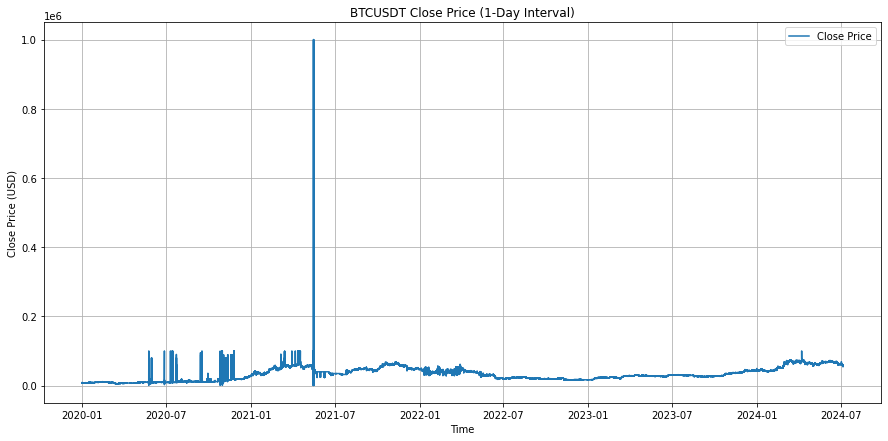

In [9]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [12]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


### Converting 1 Minute Interval Data to 8 Hour Interval Data

In [13]:
BTCUSDT_Filtered_data_8H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '8H')
BTCUSDT_Filtered_data_8H

,Open,High,Low,Close,Volume
Open time (8H),,,,,
2020-01-01 00:00:00,7169.71,9592.00,6871.45,7241.63,144575.268840
2020-01-01 08:00:00,7241.63,7243.46,7178.00,7201.02,3560.018504
2020-01-01 16:00:00,7201.56,7253.21,7187.86,7242.21,3283.091000
2020-01-02 00:00:00,7242.21,7243.41,7155.02,7169.51,3501.885115
2020-01-02 08:00:00,7169.51,7181.53,7105.17,7160.60,3373.464144
...,...,...,...,...,...
2024-07-04 00:00:00,59969.00,60998.60,58535.10,59400.00,16.654583
2024-07-04 08:00:00,59409.00,60000.00,57001.00,57890.00,23.279967
2024-07-04 16:00:00,57890.00,59111.00,56666.00,58768.00,28.687258


## Performing Back Testing

### Using Signals Generated From MACD, RSI, StochRSI & OBV On Entire Data Of 4-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [14]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_with_macd = BTCUSDT_Filtered_data_4H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (4H),,,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092,0
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587,1
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242,1
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767,1
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729,1
...,...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283,-1
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233,-1
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692,-1


### Generating Signals Using RSI Indicator Function

In [16]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_4H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (4H),,,,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092,100.000000,-1
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587,100.000000,-1
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242,66.994432,0
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767,46.186886,0
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729,58.355071,0
...,...,...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283,30.306480,0
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233,38.705490,0
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692,36.982283,0


### Generating Signals Using Stochastic RSI Indicator Function

In [17]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_4H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_4H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D,Signal
Open time (4H),,,,,,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092,0.000000,0.000000,0.000000,0
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587,0.000000,0.000000,0.000000,0
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242,0.000000,0.000000,0.000000,0
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767,0.000000,0.000000,0.000000,0
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283,0.000000,4.018464,13.378193,0
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233,0.351180,12.455467,9.131579,1
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692,0.279129,21.010330,12.494754,0


### Generating Signals Using OBV Indicator Function

In [18]:
# Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_with_obv

,Open,High,Low,Close,Volume,OBV,Signal
Open time (4H),,,,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092,0.000000,0
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587,285722.475587,1
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242,282093.471346,-1
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767,278602.438579,-1
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729,281727.737308,1
...,...,...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283,783135.387610,-1
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233,783142.495844,1
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692,783130.791152,-1


## Applying Backtesting Algorithm 1 On All Signals
### The Below Backtesting Algorithm Is Not Working Correctly
#### The Result (Ledger) Obtained Shows A Severe Bug In The Implementation
- The Trades That Are Closed Due To A TP/SL Hit Are Not Opening The Next Trade Correctly!
- Also, The TP/SL Hits Are Not Being Correctly Calculated (Only Checked On The Close Price Column)

### Applying On MACD

In [34]:
backtest_df_macd_1st = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_1st

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 04:00:00,long,7202.48,0.00,None,NaN,989.346059
1,2020-01-02 04:00:00,short,7202.48,7197.77,direction,-0.065394,989.346059
2,2020-01-02 04:00:00,short,7197.77,0.00,None,NaN,978.905540
3,2020-01-03 12:00:00,long,7197.77,7201.75,direction,-0.055295,978.905540
4,2020-01-03 12:00:00,long,7201.75,0.00,None,NaN,1019.520588
...,...,...,...,...,...,...,...
1611,2024-06-27 16:00:00,long,61786.60,61415.40,direction,0.600778,-92355.755738
1612,2024-06-27 16:00:00,long,61415.40,0.00,None,NaN,-96739.969121
1613,2024-07-01 19:43:00,short,61415.40,64945.00,tp,5.747093,-96739.969121
1614,2024-07-03 00:00:00,short,63077.30,0.00,None,NaN,-100645.509519


### Applying On RSI

In [35]:
backtest_df_rsi_1st = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_1st

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 00:00:00,short,7169.71,0.00,None,NaN,994.987649
1,2020-01-02 20:00:00,long,7169.71,7133.95,direction,0.498765,994.987649
2,2020-01-02 20:00:00,long,7133.95,0.00,None,NaN,954.426416
3,2020-01-03 06:36:00,short,7133.95,6914.47,sl,-3.076556,954.426416
4,2020-01-07 00:00:00,short,7530.81,0.00,None,NaN,915.101674
...,...,...,...,...,...,...,...
135,2024-04-14 22:36:00,short,66168.90,63279.00,sl,-4.367460,-0.441736
136,2024-05-21 04:00:00,short,66210.10,0.00,None,NaN,-0.424050
137,2024-05-21 04:23:00,long,66210.10,68199.00,sl,-3.003922,-0.424050
138,2024-06-24 12:00:00,long,64191.50,0.00,None,NaN,-0.403616


### Applying On Stochastic RSI

In [36]:
backtest_df_stochrsi_1st = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_1st

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-03 08:00:00,long,6957.16,0.00,None,NaN,1.041166e+03
1,2020-01-03 14:12:00,short,6957.16,7313.13,tp,5.116599,1.041166e+03
2,2020-01-03 16:00:00,short,7312.31,0.00,None,NaN,1.024528e+03
3,2020-01-06 04:00:00,long,7312.31,7356.04,direction,-0.598033,1.024528e+03
4,2020-01-06 04:00:00,long,7356.04,0.00,None,NaN,1.041130e+03
...,...,...,...,...,...,...,...
1657,2024-07-01 19:42:00,short,60500.00,64403.50,tp,6.452066,-1.769468e+08
1658,2024-07-01 20:00:00,short,65217.40,0.00,None,NaN,-1.848677e+08
1659,2024-07-03 08:17:00,long,65217.40,61645.80,tp,5.476453,-1.848677e+08
1660,2024-07-04 00:00:00,long,59969.00,0.00,None,NaN,-1.769492e+08


### Applying On OBV

In [37]:
backtest_df_obv_1st = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_with_obv, BTCUSDT_Filtered_data_1M)
backtest_df_obv_1st

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 04:00:00,long,7202.48,0.00,None,NaN,9.954356e+02
1,2020-01-01 08:00:00,short,7202.48,7241.63,direction,0.543563,9.954356e+02
2,2020-01-01 08:00:00,short,7241.63,0.00,None,NaN,9.909893e+02
3,2020-01-01 16:00:00,long,7241.63,7201.56,direction,0.553328,9.909893e+02
4,2020-01-01 16:00:00,long,7201.56,0.00,None,NaN,9.866732e+02
...,...,...,...,...,...,...,...
10823,2024-07-04 13:41:00,long,60715.90,57500.00,tp,5.296636,-4.438844e+21
10824,2024-07-04 20:00:00,long,57628.80,0.00,None,NaN,-4.473167e+21
10825,2024-07-05 00:00:00,short,57628.80,58650.70,direction,1.773245,-4.473167e+21
10826,2024-07-05 00:00:00,short,58650.70,0.00,None,NaN,-4.589414e+21


## Applying Backtesting Algorithm 2 On All Signals
#### This Algorithm Is Working Correctly As Far As I Know
- The Ledger Obtained Shows Correct Workings Of All Implementations!
- The Trades Are Opening & Closing Correctly

### Applying On MACD

In [38]:
backtest_df_macd_2nd = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_2nd

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 04:00:00,long,7202.48,0.00,None,NaN,1.331664e+03
1,2020-01-01 05:00:00,short,7202.48,9592.00,tp,33.176350,1.331664e+03
2,2020-01-01 08:00:00,long,7241.63,0.00,None,NaN,1.323465e+03
3,2020-01-02 04:00:00,short,7241.63,7197.77,direction,-0.605665,1.323465e+03
4,2020-01-02 04:00:00,short,7197.77,0.00,None,NaN,1.322601e+03
...,...,...,...,...,...,...,...
5511,2024-07-04 13:40:00,short,60895.70,57377.90,tp,5.776763,-3.654199e+37
5512,2024-07-04 16:00:00,short,57890.00,0.00,None,NaN,-3.768497e+37
5513,2024-07-05 02:09:00,short,57890.00,59706.50,sl,-3.137848,-3.768497e+37
5514,2024-07-05 04:00:00,short,58227.50,0.00,None,NaN,-3.658905e+37


### Applying On RSI

In [39]:
backtest_df_rsi_2nd = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_2nd

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 00:00:00,short,7169.71,0.00,None,NaN,662.049515
1,2020-01-01 05:00:00,long,7169.71,9592.00,sl,-33.785048,662.049515
2,2020-01-02 20:00:00,long,7133.95,0.00,None,NaN,641.813581
3,2020-01-03 05:45:00,long,7133.95,6916.61,sl,-3.046559,641.813581
4,2020-01-07 00:00:00,long,7530.81,0.00,None,NaN,662.034663
...,...,...,...,...,...,...,...
1017,2024-06-24 21:56:00,short,62100.00,60000.00,sl,3.381643,407592.524888
1018,2024-06-25 00:00:00,short,61722.50,0.00,None,NaN,425487.883856
1019,2024-06-25 00:55:00,short,61722.50,59006.40,sl,4.400502,425487.883856
1020,2024-07-05 08:00:00,long,56540.00,0.00,None,NaN,425445.335068


### Applying On Stochastic RSI

In [40]:
backtest_df_stochrsi_2nd = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_2nd

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-03 08:00:00,long,6957.16,0.00,None,NaN,1.050938e+03
1,2020-01-03 14:11:00,short,6957.16,7312.24,tp,5.103807,1.050938e+03
2,2020-01-03 16:00:00,short,7312.31,0.00,None,NaN,1.044548e+03
3,2020-01-06 04:00:00,long,7312.31,7356.04,direction,-0.598033,1.044548e+03
4,2020-01-06 04:00:00,long,7356.04,0.00,None,NaN,1.071815e+03
...,...,...,...,...,...,...,...
2467,2024-07-03 08:14:00,long,65217.40,61788.00,tp,-5.258413,1.214126e+08
2468,2024-07-04 00:00:00,long,59969.00,0.00,None,NaN,1.174150e+08
2469,2024-07-04 10:53:00,long,59969.00,58000.50,sl,-3.282529,1.174150e+08
2470,2024-07-04 20:00:00,long,57628.80,0.00,None,NaN,1.130660e+08


### Applying On OBV

In [41]:
backtest_df_obv_2nd = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_with_obv, BTCUSDT_Filtered_data_1M)
backtest_df_obv_2nd

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 04:00:00,long,7202.48,0.00,None,NaN,1.331664e+03
1,2020-01-01 05:00:00,short,7202.48,9592.00,tp,33.176350,1.331664e+03
2,2020-01-01 08:00:00,short,7241.63,0.00,None,NaN,1.338899e+03
3,2020-01-01 16:00:00,long,7241.63,7201.56,direction,0.553328,1.338899e+03
4,2020-01-01 16:00:00,long,7201.56,0.00,None,NaN,1.346322e+03
...,...,...,...,...,...,...,...
12521,2024-07-04 20:00:00,long,57890.00,57628.80,direction,0.451201,1.237432e+43
12522,2024-07-04 20:00:00,long,57628.80,0.00,None,NaN,1.259251e+43
12523,2024-07-05 00:00:00,short,57628.80,58650.70,direction,1.773245,1.259251e+43
12524,2024-07-05 00:00:00,short,58650.70,0.00,None,NaN,1.326772e+43


## Time Analysis For Both The Codes (The Correct Implementation As Well As The Incorrect One)

# ***More Later!***